![Logo 1](img/aitech-logotyp-1.jpg)
<div class="alert alert-block alert-info">
<h1> Widzenie komputerowe </h1>
<h2> 10. <i>Metody głębokiego uczenia (2)</i> [laboratoria]</h2> 
<h3>Andrzej Wójtowicz (2021)</h3>
</div>

![Logo 2](img/aitech-logotyp-2.jpg)

W poniższym materiale zobaczymy w jaki sposób korzystać z wytrenowanych modeli sieci neuronowych w zagadnieniach związanych z wykrywaniem wielu obiektów, szacowaniem pozy człowieka, wykrywaniem i rozpoznawaniem tekstu oraz super rozdzielczością.

Uwaga: realizacja poniższych treści będzie wymagała pobrania ok. 700 MB danych.

Na początku załadujmy niezbędne biblioteki:

In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Pobrane pliki będziemy zapisywać w katalogu `dnn`:

In [2]:
!mkdir -p dnn

# Wykrywanie obiektów

## SSD

W poprzednich materiałach korzystaliśmy z [SSD](https://arxiv.org/pdf/1512.02325.pdf) do wykrywania wielu twarzy na zdjęciu. W poniższym przykładzie możemy zobaczyć użycie do wykrywania wielu obiektów  - sieć została wytrenowana na zbiorze [Common Objects in Context](https://cocodataset.org/) (COCO). Użyjemy modelu dostępnego dla frameworku [Tensorflow](https://github.com/tensorflow/models/tree/master/research/object_detection) (inne modele możemy znaleźć w [Detection Model Zoo](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/tf1_detection_zoo.md)):

In [3]:
!wget -q --show-progress -O dnn/ssd_mobilenet_v2_coco_2018_03_29.tar.gz http://download.tensorflow.org/models/object_detection/ssd_mobilenet_v2_coco_2018_03_29.tar.gz
!cd dnn && tar xzf ssd_mobilenet_v2_coco_2018_03_29.tar.gz && rm ssd_mobilenet_v2_coco_2018_03_29.tar.gz

dnn/ssd_mobilenet_v 100%[===================>] 179.22M  15.6MB/s    in 11s     


Pobraliśmy model i generujemy konfigurację:

In [4]:
!wget -q --show-progress -O dnn/ssd_mobilenet_v2_coco_2018_03_29/tf_text_graph_ssd.py https://raw.githubusercontent.com/opencv/opencv/4.5.3/samples/dnn/tf_text_graph_ssd.py
!wget -q --show-progress -O dnn/ssd_mobilenet_v2_coco_2018_03_29/tf_text_graph_common.py https://raw.githubusercontent.com/opencv/opencv/4.5.3/samples/dnn/tf_text_graph_common.py
!cd dnn/ssd_mobilenet_v2_coco_2018_03_29 && python3 tf_text_graph_ssd.py --input frozen_inference_graph.pb --output net.pbtxt --config pipeline.config

dnn/ssd_mobilenet_v 100%[===================>]  17.88K  --.-KB/s    in 0.004s  
dnn/ssd_mobilenet_v 100%[===================>]   9.82K  --.-KB/s    in 0.002s  
/home/students/s478839/Desktop/WKO/aitech-wko-pub/dnn/ssd_mobilenet_v2_coco_2018_03_29/tf_text_graph_ssd.py:273: SyntaxWarning: "is" with a literal. Did you mean "=="?
  for label in ['ClassPredictor', 'BoxEncodingPredictor' if box_predictor is 'convolutional' else 'BoxPredictor']:
/home/students/s478839/Desktop/WKO/aitech-wko-pub/dnn/ssd_mobilenet_v2_coco_2018_03_29/tf_text_graph_ssd.py:278: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if box_predictor is 'convolutional':
/home/students/s478839/Desktop/WKO/aitech-wko-pub/dnn/ssd_mobilenet_v2_coco_2018_03_29/tf_text_graph_ssd.py:311: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if box_predictor is 'convolutional':
Scale: [0.200000-0.950000]
Aspect ratios: [1.0, 2.0, 0.5, 3.0, 0.333299994469]
Reduce boxes in the lowest layer: True
Number of classes: 90
Num

Wczytujemy model:

In [5]:
model = cv.dnn.readNetFromTensorflow("dnn/ssd_mobilenet_v2_coco_2018_03_29/frozen_inference_graph.pb",
                                     "dnn/ssd_mobilenet_v2_coco_2018_03_29/net.pbtxt")

Pobieramy i wczytujemy etykiety klas obiektów:

In [6]:
!wget -q -O - https://raw.githubusercontent.com/tensorflow/models/master/research/object_detection/data/mscoco_complete_label_map.pbtxt | grep display_name | grep -o '".*"' | tr -d '"' > dnn/ssd_mobilenet_v2_coco_2018_03_29/coco-labels.txt

In [7]:
with open('dnn/ssd_mobilenet_v2_coco_2018_03_29/coco-labels.txt', 'r') as f_fd:
    classes = f_fd.read().splitlines()
    
print(len(classes), classes[:5])

91 ['background', 'person', 'bicycle', 'car', 'motorcycle']


Spróbujemy sprawdzić jakie obiekty znajdują się na poniższym zdjęciu:

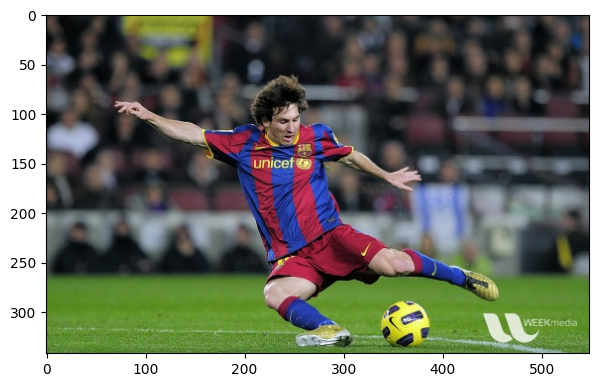

In [8]:
image = cv.imread('img/messi5.jpg')
plt.figure(figsize=[7,7])
plt.imshow(image[:,:,::-1]);

Sieć zwraca nam listę obiektów z oznaczeniem współrzędnych na zdjęciu oraz identyfikatorem obiektu (ustawiliśmy próg odcięcia na 0.5):

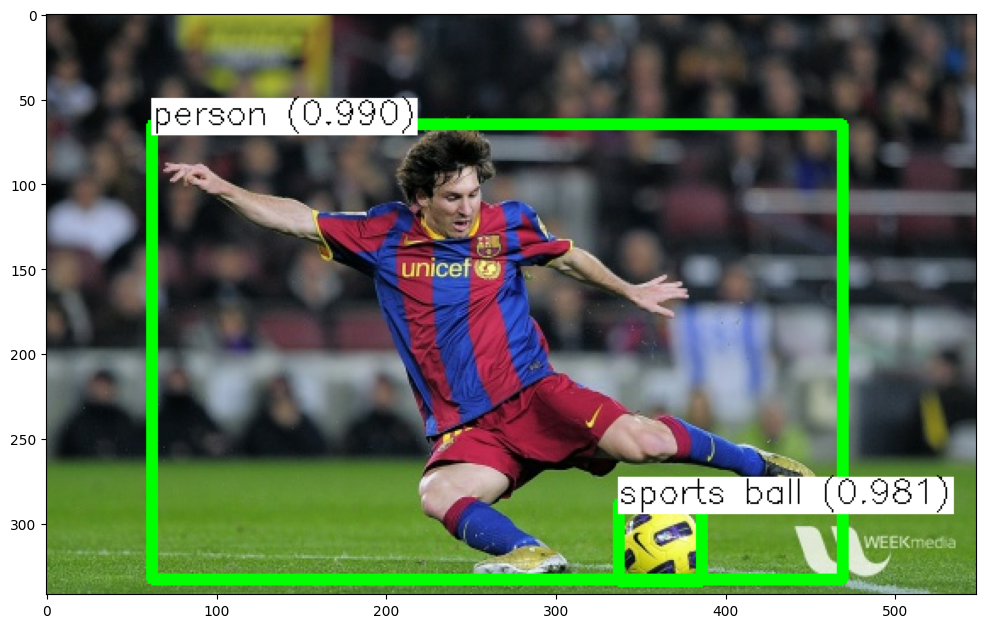

In [9]:
height, width, _ = image.shape

image_blob = cv.dnn.blobFromImage(image=image, scalefactor=1, size=(300, 300), mean=(0,0,0), 
                                  swapRB=True, crop=False)

model.setInput(image_blob)
detections = model.forward()

image_out = image.copy()

for i in range(detections.shape[2]):
    confidence = detections[0, 0, i, 2]
    if confidence > 0.5:

        box = detections[0, 0, i, 3:7] * np.array([width, height, width, height])
        (x1, y1, x2, y2) = box.astype('int')
        
        class_id = int(detections[0, 0, i, 1])

        cv.rectangle(image_out, (x1, y1), (x2, y2), (0, 255, 0), 6)
        label = '{:} ({:.3f})'.format(classes[class_id], confidence)
        label_size, base_line = cv.getTextSize(label, cv.FONT_HERSHEY_SIMPLEX, 0.65, 1)
        cv.rectangle(image_out, (x1, y1 - label_size[1]), (x1 + label_size[0], y1 + base_line), 
                      (255, 255, 255), cv.FILLED)
        cv.putText(image_out, label, (x1, y1), cv.FONT_HERSHEY_SIMPLEX, 0.65, (0, 0, 0))
        
plt.figure(figsize=[12,12])
plt.imshow(image_out[:,:,::-1]);

## YOLOv4

Innym popularnym modelem do wykrywania obiektów jest [You Only Look Once](https://github.com/AlexeyAB/darknet) (YOLO). Porównując YOLO do innych sieci, model ten nie analizuje poszczególnych regionów, ale patrzy na obraz całościowo, co w pewien sposób stanowi balans między szybkością a precyzją. Ze względu na tę cechę model ten dobrze nadaje się do wykrywania obiektów w czasie rzeczywistym. Model powinien dobrze sobie radzić gdy zostanie mu przedstawiona nieznana wcześniej reprezentacja obiektu (np. zacieniony) lub gdy obiekt znajduje się w otoczeniu innych nieoczekiwanych obiektów.

YOLO jest dostępne w kilku wersjach, natomiast my sprawdzimy jak sobie radzi wersja kompaktowa:

In [10]:
!mkdir -p dnn/yolo_v4_tiny
!wget -q --show-progress -O dnn/yolo_v4_tiny/yolov4-tiny.weights https://github.com/AlexeyAB/darknet/releases/download/yolov4/yolov4-tiny.weights
!wget -q --show-progress -O dnn/yolo_v4_tiny/yolov4-tiny.cfg https://raw.githubusercontent.com/AlexeyAB/darknet/master/cfg/yolov4-tiny.cfg
!wget -q --show-progress -O dnn/yolo_v4_tiny/coco.names https://raw.githubusercontent.com/AlexeyAB/darknet/master/cfg/coco.names

dnn/yolo_v4_tiny/yo 100%[===================>]  23.13M  11.8MB/s    in 2.0s    
dnn/yolo_v4_tiny/yo 100%[===================>]   3.16K  --.-KB/s    in 0.001s  
dnn/yolo_v4_tiny/co 100%[===================>]     625  --.-KB/s    in 0s      


Wczytujemy model:

In [11]:
model = cv.dnn.readNetFromDarknet("dnn/yolo_v4_tiny/yolov4-tiny.cfg", 
                                  "dnn/yolo_v4_tiny/yolov4-tiny.weights")

Wczytujemy etykiety obiektów:

In [12]:
with open('dnn/yolo_v4_tiny/coco.names', 'r') as f_fd:
    classes = f_fd.read().splitlines()
    
print(len(classes), classes[:5])

80 ['person', 'bicycle', 'car', 'motorbike', 'aeroplane']


Przetestujemy działanie na poniższym zdjęciu:

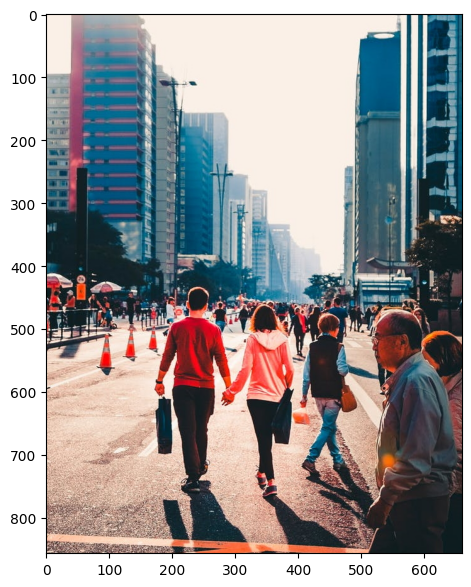

In [13]:
image = cv.imread('img/pedestrians.jpg')
plt.figure(figsize=[7,7])
plt.imshow(image[:,:,::-1]);

Podczas korzystania z tego modelu musimy się zmierzyć z kilkoma subtelnościami. Model wykorzystuje framework Darknet, więc musimy wskazać, że chodzi nam o predykcje pochodzące z ostatniej warstwy. Dodatkowo mamy kilka progów odcięcia do zdefiniowania, tj. miarę obiektowości (*objectness*), pewności (*confidence*) oraz tłumienia niemaksymalnego aby ograniczyć występowanie nakładających się na siebie ramek z wykrytymi obiektami (por. [`cv.dnn.NMSBoxes()`](https://docs.opencv.org/4.5.3/d6/d0f/group__dnn.html#ga9d118d70a1659af729d01b10233213ee)). Poniżej mamy wynik działania:

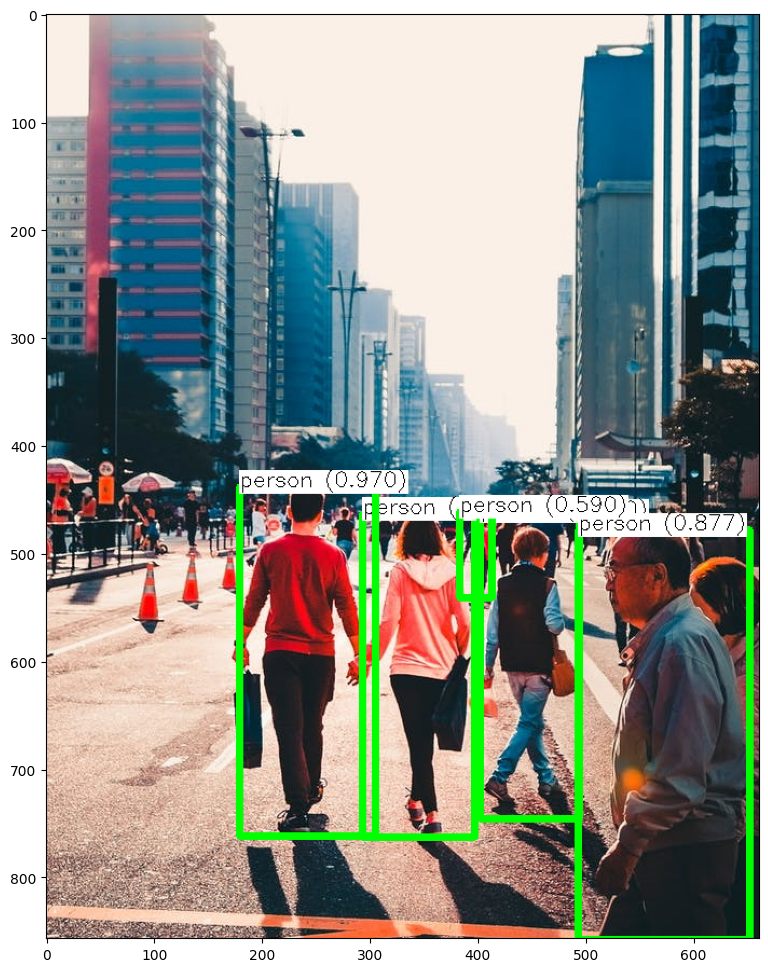

In [14]:
height, width, _ = image.shape

image_blob = cv.dnn.blobFromImage(image=image, scalefactor=1/255, size=(416, 416), mean=(0,0,0), 
                                  swapRB=True, crop=False)

model.setInput(image_blob)
detections = model.forward([model.getLayerNames()[i[0] - 1] for i in model.getUnconnectedOutLayers()])

image_out = image.copy()

class_ids = []
confidences = []
boxes = []

for out in detections:
    for detection in out:
        if detection[4] > 0.5: # objectness thr.
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]
            if confidence > 0.5: # confidence thr.
                center_x = int(detection[0] * width)
                center_y = int(detection[1] * height)
                b_width = int(detection[2] * width)
                b_height = int(detection[3] * height)

                b_left = int(center_x - b_width / 2)
                b_top = int(center_y - b_height / 2)
                class_ids.append(class_id)
                confidences.append(float(confidence))
                boxes.append([b_left, b_top, b_width, b_height])

indices = cv.dnn.NMSBoxes(boxes, confidences, score_threshold=0.5, nms_threshold=0.5)
for i in indices:
    idx = i[0]
    box = boxes[idx]
    x1 = box[0]
    y1 = box[1]
    x2 = box[0] + box[2]
    y2 = box[1] + box[3]
    cv.rectangle(image_out, (x1, y1), (x2, y2), (0, 255, 0), 6)
    label = '{:} ({:.3f})'.format(classes[class_ids[idx]], confidences[idx])
    
    label_size, base_line = cv.getTextSize(label, cv.FONT_HERSHEY_SIMPLEX, 0.65, 1)
    cv.rectangle(image_out, (x1, y1 - label_size[1]), (x1 + label_size[0], y1 + base_line), 
                  (255, 255, 255), cv.FILLED)
    cv.putText(image_out, label, (x1, y1), cv.FONT_HERSHEY_SIMPLEX, 0.65, (0, 0, 0))
        
plt.figure(figsize=[12,12])
plt.imshow(image_out[:,:,::-1]);

# Szacowanie pozy człowieka

Kolejnym interesującym zagadnieniem jest szacowanie pozy człowieka (ang. *human pose estimation*) na podstawie zdjęcia. Celem jest tutaj wykrycie charakterystycznych punktów orientacyjnych, które mogą potem zostać wykorzystane np. treningu sportowego, kontroli gestów, korekcji postawy, itp. W tym celu wykorzystamy [OpenPose](https://github.com/CMU-Perceptual-Computing-Lab/openpose).

In [15]:
!mkdir -p dnn/openpose
!wget -q --show-progress -O dnn/openpose/pose_iter_160000.caffemodel http://posefs1.perception.cs.cmu.edu/Users/tsimon/Projects/coco/data/models/mpi/pose_iter_160000.caffemodel
!wget -q --show-progress -O dnn/openpose/pose_deploy_linevec_faster_4_stages.prototxt https://raw.githubusercontent.com/CMU-Perceptual-Computing-Lab/openpose/master/models/pose/mpi/pose_deploy_linevec_faster_4_stages.prototxt

dnn/openpose/pose_i 100%[===================>] 196.41M  17.4MB/s    in 19s     
dnn/openpose/pose_d 100%[===================>]  31.46K  --.-KB/s    in 0.008s  


Wczytujemy model:

In [16]:
model = cv.dnn.readNetFromCaffe("dnn/openpose/pose_deploy_linevec_faster_4_stages.prototxt",
                                "dnn/openpose/pose_iter_160000.caffemodel")

Będziemy chcieli przeanalizować poniższe zdjęcie:

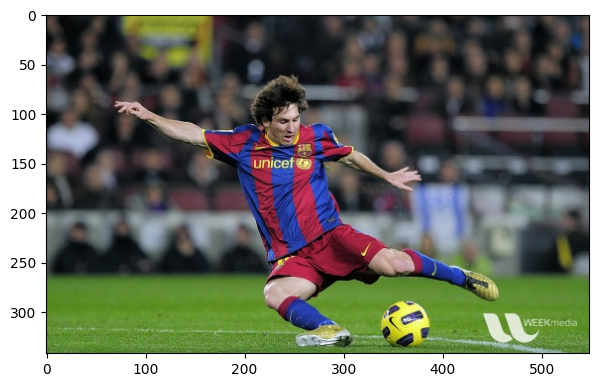

In [17]:
image = cv.imread("img/messi5.jpg")
plt.figure(figsize=[7,7])
plt.imshow(image[:,:,::-1]);

Zdefinujemy poniżej połączenia pomiędzy 15 punktami orientacyjnymi:

In [18]:
pose_points_n = 15
pose_pairs = [[0,1], [1,2], [2,3], [3,4], [1,5], [5,6], [6,7], [1,14], [14,8], [8,9], [9,10], [14,11], [11,12], [12,13]]

W wyniku otrzymujemy mapy prawodpodobieństwa występowania danego punktu orientacyjnego:

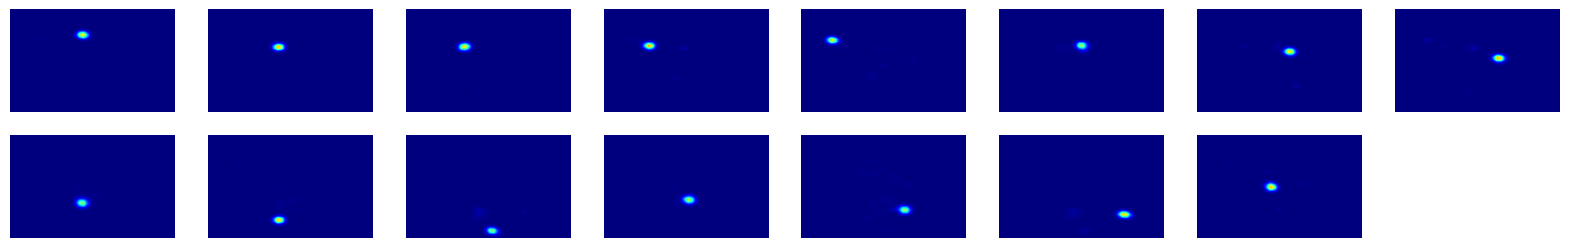

In [19]:
height, width, _ = image.shape

image_blob = cv.dnn.blobFromImage(image, 1.0/255, (368, 368), (0, 0, 0), swapRB=False, crop=False)
model.setInput(image_blob)

output = model.forward()

plt.figure(figsize=(20,3))
for i in range(pose_points_n):
    prob_map = output[0, i, :, :]
    disp_map = cv.resize(prob_map, (width, height), cv.INTER_LINEAR)
    plt.subplot(2, 8, i+1)
    plt.axis('off')
    plt.imshow(disp_map, cmap='jet', vmin=0, vmax=1)

Przeskalowujemy wyniki do rozmiarów obrazu wejściowego i przy pomocy [`cv.minMaxLoc()`](https://docs.opencv.org/4.5.3/d2/de8/group__core__array.html#gab473bf2eb6d14ff97e89b355dac20707) znajdujemy wartość maksymalną (dodatkowo sprawdzamy czy wartość prawdopodobieństwa jest odpowiednio duża):

In [20]:
scale_x = width / output.shape[3]
scale_y = height / output.shape[2]

points = []

for i in range(pose_points_n):
    prob_map = output[0, i, :, :]
    
    _, prob, _, point = cv.minMaxLoc(prob_map)
    
    x = scale_x * point[0]
    y = scale_y * point[1]

    if prob > 0.1: # thr.
        points.append((int(x), int(y)))
    else:
        points.append(None)

Możemy teraz nanieść punkty na obraz i połączyć je w szkielet

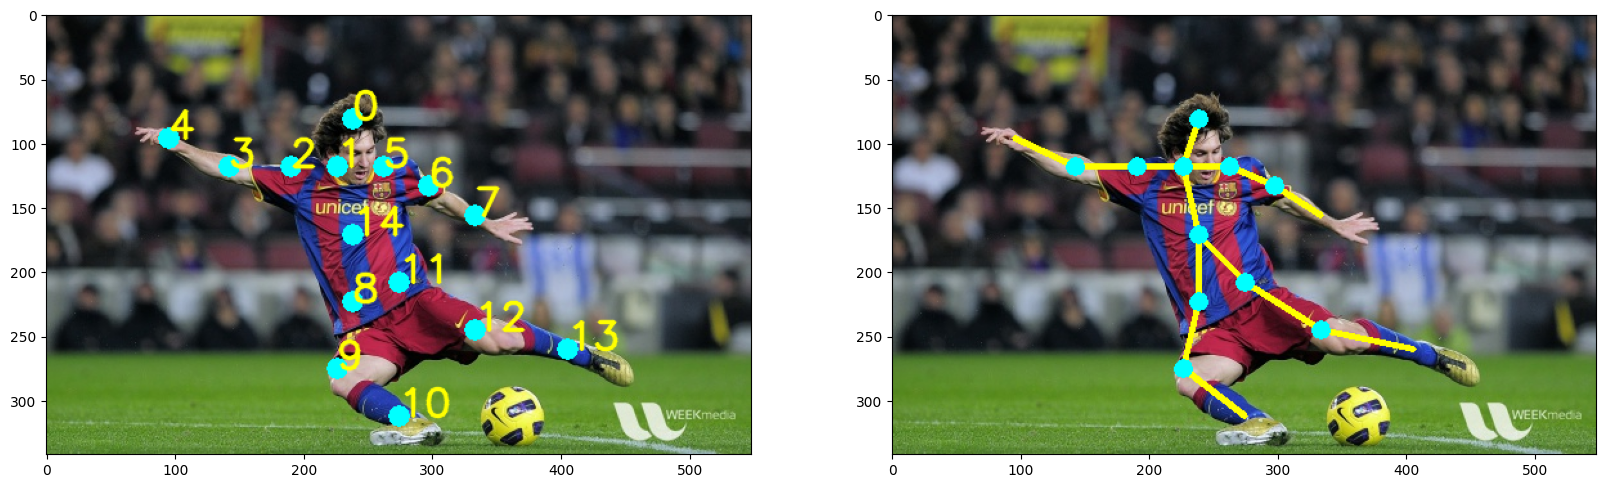

In [21]:
image_points = image.copy()
image_skeleton = image.copy()

for i, p in enumerate(points):
    cv.circle(image_points, p, 8, (255, 255, 0), thickness=-1, lineType=cv.FILLED)
    cv.putText(image_points, "{}".format(i), p, cv.FONT_HERSHEY_SIMPLEX, 1, (0,255,255), 2, lineType=cv.LINE_AA)


for pair in pose_pairs:
    part_a = pair[0]
    part_b = pair[1]

    if points[part_a] and points[part_b]:
        cv.line(image_skeleton, points[part_a], points[part_b], (0, 255, 255), 4)
        cv.circle(image_skeleton, points[part_a], 7, (255, 255, 0), thickness=-1, lineType=cv.FILLED)

plt.figure(figsize=(20,20))
plt.subplot(121)
plt.imshow(image_points[:,:,::-1])
plt.subplot(122)
plt.imshow(image_skeleton[:,:,::-1]);

# Wykrywanie i rozpoznawanie tekstu

W kolejnym przykładzie zobaczymy jak możemy wykryć na zdjęciu tekst przy pomocy [DB](https://github.com/MhLiao/DB) oraz rozpoznać go przy pomocy [CRNN](https://arxiv.org/pdf/1507.05717.pdf).

In [23]:
!pip install gdown

Defaulting to user installation because normal site-packages is not writeable
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
--- Logging error ---
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/pip/_internal/utils/logging.py", line 177, in emit
    self.console.print(renderable, overflow="ignore", crop=False, style=style)
  File "/usr/local/lib/python3.9/dist-packages/pip/_vendor/rich/console.py", line 1673, in print
    extend(render(renderable, render_options))
  File "/usr/local/lib/python3.9/dist-packages/pip/_vendor/rich/console.py", line 1305, in render
    for render_output in iter_render:
  File "/usr/local/lib/python3.9/dist-packages/pip/_internal/utils/logging.py", line 134, in __rich_console__
    for line in lines:
  File "/usr/local/lib/python3.9/dist-packages/pip/_vendor/rich/segment.py", line 249, in split_lines
    for segment in segments:
  File "/usr/local/lib/pytho

In [24]:
import gdown

for url, output in [('https://drive.google.com/uc?export=dowload&id=19YWhArrNccaoSza0CfkXlA8im4-lAGsR', 'dnn/DB_TD500_resnet50.onnx'), 
                    ('https://drive.google.com/uc?export=dowload&id=12diBsVJrS9ZEl6BNUiRp9s0xPALBS7kt', 'dnn/crnn_cs.onnx'),
                    ('https://drive.google.com/uc?export=dowload&id=1oKXxXKusquimp7XY1mFvj9nwLzldVgBR', 'dnn/alphabet_94.txt')]:
    gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?export=dowload&id=19YWhArrNccaoSza0CfkXlA8im4-lAGsR
To: /home/students/s478839/Desktop/WKO/aitech-wko-pub/dnn/DB_TD500_resnet50.onnx
100%|██████████| 101M/101M [00:04<00:00, 22.5MB/s] 
Downloading...
From: https://drive.google.com/uc?export=dowload&id=12diBsVJrS9ZEl6BNUiRp9s0xPALBS7kt
To: /home/students/s478839/Desktop/WKO/aitech-wko-pub/dnn/crnn_cs.onnx
100%|██████████| 64.9M/64.9M [00:03<00:00, 19.2MB/s]
Downloading...
From: https://drive.google.com/uc?export=dowload&id=1oKXxXKusquimp7XY1mFvj9nwLzldVgBR
To: /home/students/s478839/Desktop/WKO/aitech-wko-pub/dnn/alphabet_94.txt
100%|██████████| 188/188 [00:00<00:00, 527kB/s]


Będziemy pracować na poniższym zdjęciu:

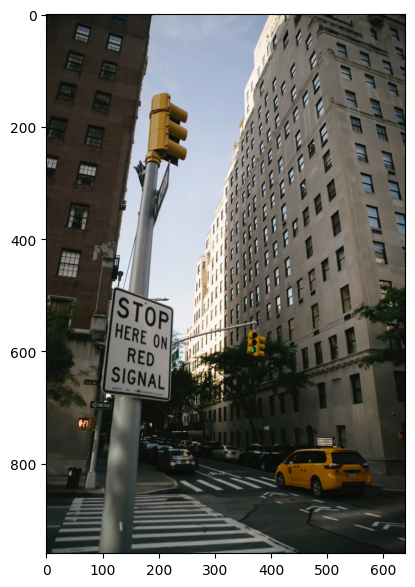

In [25]:
image = cv.imread('img/road-sign.jpg')

plt.figure(figsize=(5,7))
plt.imshow(image[:,:,::-1]);

Wczytujemy obsługiwany alfabet:

In [26]:
with open('dnn/alphabet_94.txt', 'r') as f_fd:
    alphabet = f_fd.read().splitlines()
    
print(len(alphabet), alphabet[:15])

94 ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c', 'd', 'e']


OpenCV posiada gotowe API dla sieci DB poprzez [`cv.dnn_TextDetectionModel_DB()`](https://docs.opencv.org/4.5.3/db/d0f/classcv_1_1dnn_1_1TextDetectionModel__DB.html):

In [27]:
text_detector = cv.dnn_TextDetectionModel_DB("dnn/DB_TD500_resnet50.onnx")

text_detector.setBinaryThreshold(0.4).setPolygonThreshold(0.5)
text_detector.setInputParams(scale=1.0/255, size=(640, 640), 
                             mean=(122.67891434, 116.66876762, 104.00698793), swapRB=True)

W wyniku otrzymujemy ramki, na których występuje tekst (choć jak widzimy, są też wyniki fałszywie pozytywne):

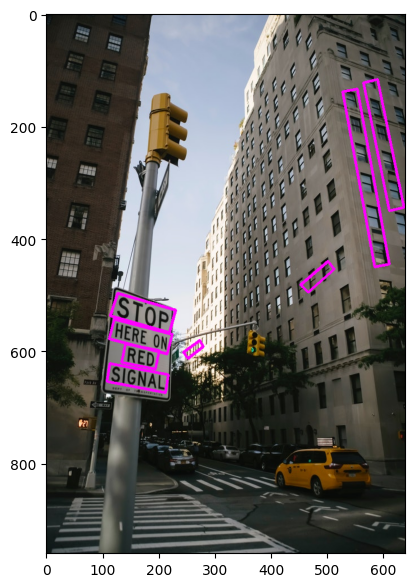

In [28]:
boxes, confs = text_detector.detect(image)

image_out = image.copy()

cv.polylines(image_out, boxes, True, (255, 0, 255), 4)

plt.figure(figsize=(5,7))
plt.imshow(image_out[:,:,::-1]);

W kolejnym kroku przygotowujemy model do rozpoznawania tekstu przy pomocy [`cv.dnn_TextRecognitionModel()`](https://docs.opencv.org/4.5.3/de/dee/classcv_1_1dnn_1_1TextRecognitionModel.html):

In [29]:
text_recognizer = cv.dnn_TextRecognitionModel("dnn/crnn_cs.onnx")
text_recognizer.setDecodeType("CTC-greedy")
text_recognizer.setVocabulary(alphabet)
text_recognizer.setInputParams(scale=1/127.5, size=(100, 32), mean=(127.5, 127.5, 127.5), swapRB=True)

Każdą wykrytą ramkę rzutujemy na rozmiar 100x32 i wykrywamy tekst:

In [30]:
for box in boxes:
    vertices = np.asarray(box).astype(np.float32)
    output_size = (100, 32)
    target_vertices = np.array([
        [0, output_size[1] - 1],
        [0, 0],
        [output_size[0] - 1, 0],
        [output_size[0] - 1, output_size[1] - 1]],
        dtype="float32")
    rotation_matrix = cv.getPerspectiveTransform(vertices, target_vertices)
    cropped_roi = cv.warpPerspective(image, rotation_matrix, output_size)
    
    result = text_recognizer.recognize(cropped_roi)
    print(result)

SIGNAL
RED
you
HEREON
STOP
Fe
a
a


# Super rozdzielczość

Podczas zwiększania rozdzielczości brakujące piksele muszą być w jakiś sposób interpolowane. Przy niewielkich powiększeniach zwykle wystarczą nam tradycyjne metody, jednak jeśli pracujemy z obrazem w niskiej rozdzielczości i chcemy go znacząco powiększyć, to chcielibyśmy również uzyskać wysoką jakość np. poprzez uwzględnienie informacji z otoczenia pikseli. Problematyka ta dotyczy zagadnienia super rozdzielczości (ang. *super-resolution*).

W [artykule](https://arxiv.org/pdf/1902.06068.pdf) z 2020 r. możemy znaleźć porównanie dostępnych w tamtym czasie modeli (zob. wykres na str. 15); np. możemy zobaczyć, że model [EDSR](https://github.com/Saafke/EDSR_Tensorflow) radzi sobie całkiem nieźle, aczkolwiek kosztem sporego narzutu obliczeniowego (por. również benchmarki [OpenCV](https://github.com/opencv/opencv_contrib/blob/master/modules/dnn_superres/README.md)). Przetestujemy EDSR na powiększeniu 4-krotnym:

In [31]:
!wget -q --show-progress -O dnn/EDSR_x4.pb https://raw.githubusercontent.com/Saafke/EDSR_Tensorflow/master/models/EDSR_x4.pb

dnn/EDSR_x4.pb      100%[===================>]  36.79M  7.00MB/s    in 5.1s    


Przy pomocy [`cv.dnn_superres.DnnSuperResImpl_create()`](https://docs.opencv.org/4.5.3/d8/d11/classcv_1_1dnn__superres_1_1DnnSuperResImpl.html) przygotowujemy model:

In [32]:
sr = cv.dnn_superres.DnnSuperResImpl_create()
sr.readModel('dnn/EDSR_x4.pb')
sr.setModel('edsr', 4)

Następnie zwiększy rozdzielczość zadanego obrazu (operacja może zająć trochę czasu):

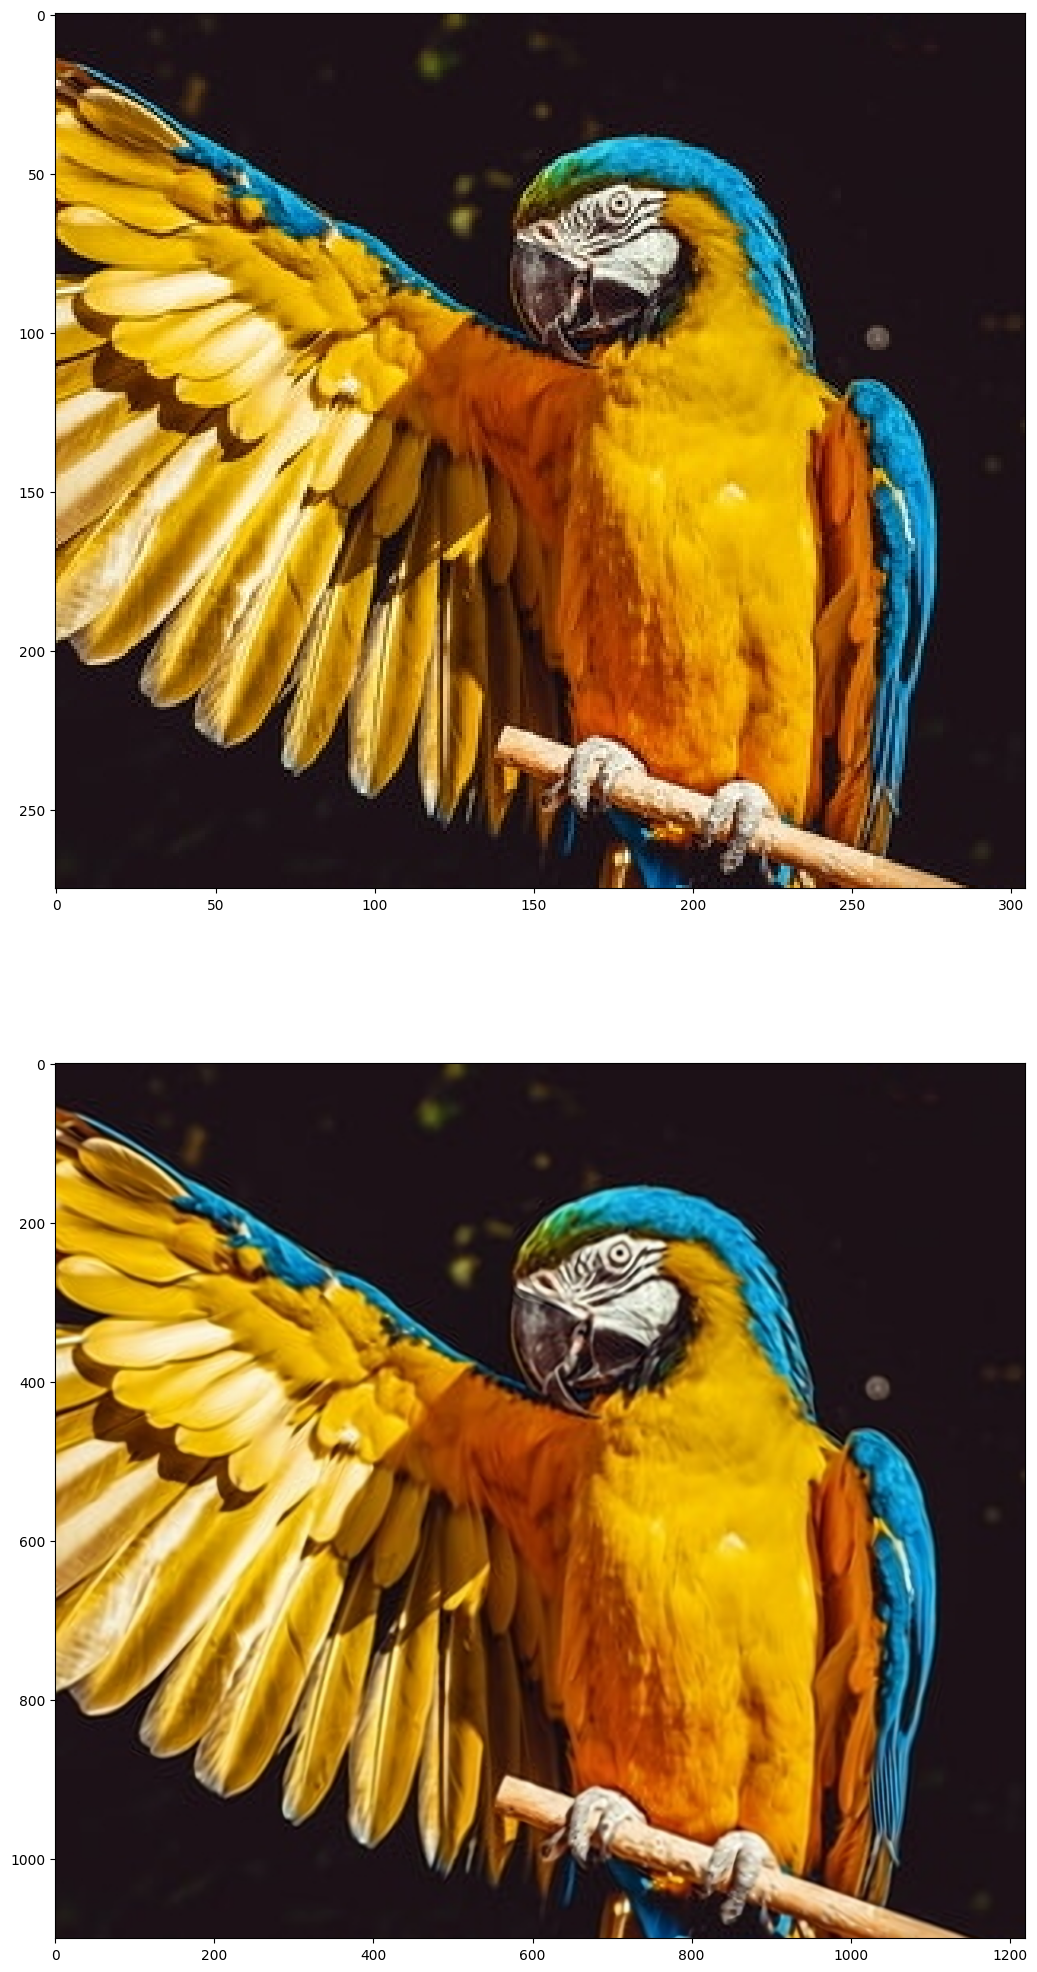

In [33]:
image = cv.imread('img/parrot.jpg')

image_EDSR = sr.upsample(image)

plt.figure(figsize=(25,25))
plt.subplot(211)
plt.imshow(image[:,:,::-1])
plt.subplot(212)
plt.imshow(image_EDSR[:,:,::-1]);

# Zadanie 1

Przy pomocy biblioteki [MediaPipe](https://google.github.io/mediapipe/solutions/selfie_segmentation.html) dokonaj podmień tło w selfie `img/selfie-man.jpg` na `img/selfie-background.jpg` (możesz również odbić obraz w poziomie).

![Wynik działania programu](img/selfie-out.png)

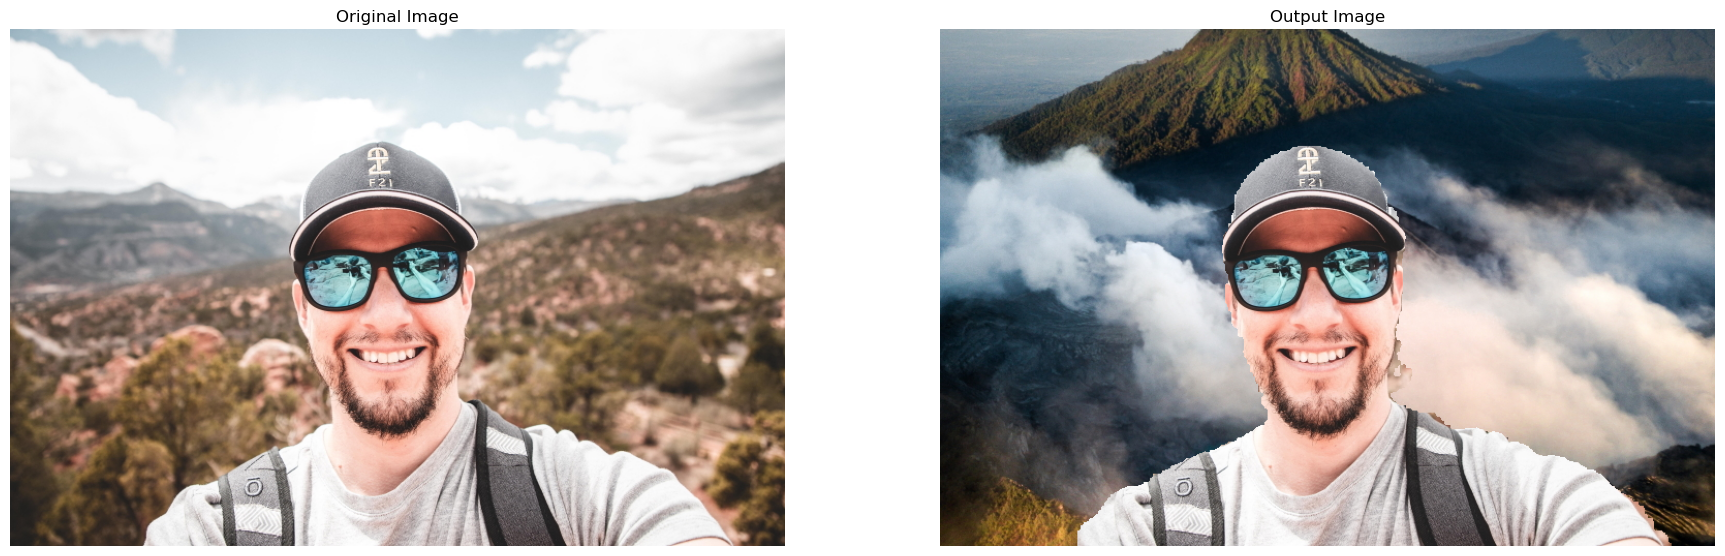

In [3]:
import cv2 as cv
import numpy as np
import mediapipe as mp
import matplotlib.pyplot as plt

selfie_man = cv.imread('img/selfie-man.jpg')
selfie_background = cv.imread('img/selfie-background.jpg')

change_background_mp = mp.solutions.selfie_segmentation
change_bg_segment = change_background_mp.SelfieSegmentation()

RGB_selfie_man = cv2.cvtColor(selfie_man, cv2.COLOR_BGR2RGB)

result = change_bg_segment.process(RGB_selfie_man)
binary_mask = result.segmentation_mask > 0.9
binary_mask_3 = np.dstack((binary_mask,binary_mask,binary_mask))
output_image = np.where(binary_mask_3, selfie_man, 255)
output_image = np.where(binary_mask_3, selfie_man, selfie_background)    

plt.figure(figsize=[22,22])
plt.subplot(121);plt.imshow(selfie_man[:,:,::-1]);plt.title("Original Image");plt.axis('off');
plt.subplot(122);plt.imshow(output_image[:,:,::-1]);plt.title("Output Image");plt.axis('off');